In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib as plt
import operator


In [2]:
df = pd.read_csv('Reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [3]:
def data_clean(df, feature, x):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > x].index)]
    return df
def arrange_data(df,features,x):
    fil = df.ProductId.value_counts()
    fil2 = df.UserId.value_counts()
    df['#Proudcts'] = df.ProductId.apply(lambda n: fil[n])
    df['#Users'] = df.UserId.apply(lambda n: fil2[n])
    while (df.ProductId.value_counts(ascending=True)[0]) < x or  (df.UserId.value_counts(ascending=True)[0] < x):
        df = data_clean(df,features[0],x)
        df = data_clean(df,features[1],x)
    return df
processed_data_frame = arrange_data(df, ['ProductId', 'UserId'], 10)

In [35]:
processed_data_frame.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,#Proudcts,#Users
422,423,B000G6RYNE,A2NO1TXXS9T0EE,BruteNStones,0,0,4,1335398400,Hard,"Great if you are cutting back on fat, they do ...",217,44
423,424,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",0,0,5,1334620800,Kettle potato chips: Fully loaded baked potato,I have never met a Kettle brand chip I did not...,217,49
424,425,B000G6RYNE,ARONI7W0W677H,Peter N,0,0,5,1334275200,"Fresh, Lightly-Spiced, Crunchy Kettle Chips. G...",After buying bags one at a time (at a hefty ma...,217,16
425,426,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b...",217,32
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,"pretty good, could be better",Glad to find these in a one ounce size but the...,217,32


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214C08190F0>,
      dtype=object)

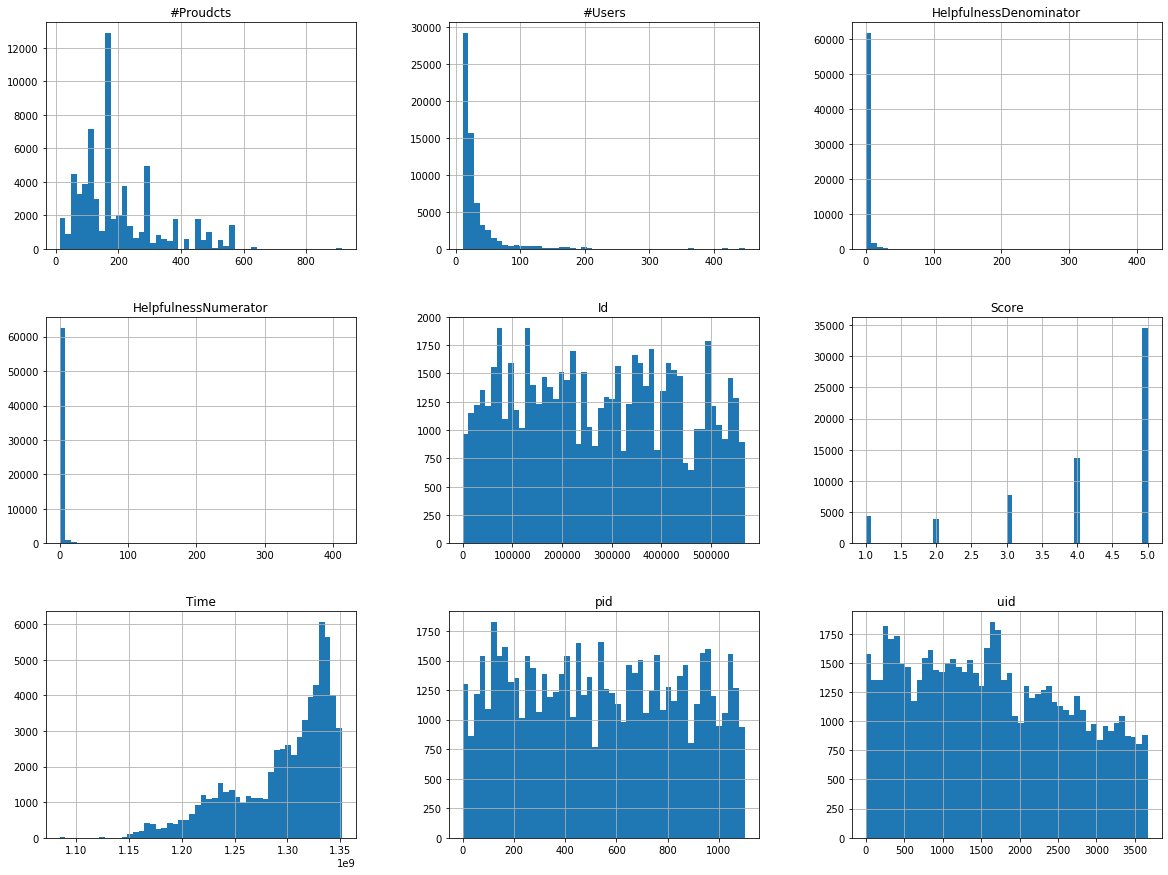

In [36]:
processed_data_frame['uid'] = pd.factorize(processed_data_frame['UserId'])[0]
processed_data_frame['pid'] = pd.factorize(processed_data_frame['ProductId'])[0]
processed_data_frame.hist(bins = 50, figsize = (20,15))

In [37]:
sc = MinMaxScaler()
processed_data_frame['time']=sc.fit_transform(processed_data_frame['Time'].values.reshape(-1,1))
processed_data_frame['nuser']=sc.fit_transform(processed_data_frame['#Users'].values.reshape(-1,1))
processed_data_frame['nproduct']=sc.fit_transform(processed_data_frame['#Proudcts'].values.reshape(-1,1))

In [38]:
X = processed_data_frame.loc[:,['uid','pid','time','nuser','nproduct']]
Y = processed_data_frame.Score
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=2017)

In [48]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train,Y_train)
Y_test_predict = model.predict(X_test)

In [49]:
temp1 = mean_squared_error(Y_test,Y_test_predict)
print('Mean square error on testing data: ',temp1)


recommendation_accuracy = Y_test_predict >= 4
temp1 = Y_test >= 4

no_recommendation_accuracy = Y_test_predict < 3
temp2 = Y_test < 3

print('Accuracy score of recommendation: ',accuracy_score(temp1,recommendation_accuracy))
print('Accuracy score of not recommendation: ',accuracy_score(temp2,no_recommendation_accuracy))

Y_pred_array = []
Y_test_array = []
for i in range(Y_test_predict.shape[0]):
    if Y_test_predict[i] >= 4:
        Y_pred_array.append(1)
    elif Y_test_predict[i] < 4:
        Y_pred_array.append(0)

for j in range(Y_test_predict.shape[0]):
    if np.array(Y_test)[j] >= 4:
        Y_test_array.append(1)
    elif np.array(Y_test)[j]<4:
        Y_test_array.append(0)
        
classes = ['not recommand','recommand']
cm = confusion_matrix(Y_test_array,Y_pred_array)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Confusion matrix")
print(cm)

Mean square error on testing data:  0.538819379684316
Accuracy score of recommendation:  0.9036887369184541
Accuracy score of not recommendation:  0.950419645632577
Confusion matrix
[[0.81903595 0.18096405]
 [0.0675413  0.9324587 ]]


In [50]:
prid = processed_data_frame.ProductId
score = processed_data_frame.Score
def recomned_product(data_framee,prid_array,score_array,score_predicted):
    pid_score = dict()
    for i in range(len(prid_array)):
        if score_array[i] >= score_predicted:
            if prid_array[i] in pid_score.keys() and score_array[i] >= score_predicted:
                pid_score[prid_array[i]] = pid_score[prid_array[i]]+1
            else:
                pid_score[prid_array[i]] = 0
    pid_score_sorted = {}
    pid_score_sorted = dict(sorted(pid_score.items(), key=operator.itemgetter(1),reverse = True))
    type(pid_score_sorted)
    print("recommended product for given data of user")
    c = 0
    product = []
    for i in pid_score_sorted:
        product.append(i)
        c = c+1
        if c == 10:
            return product;
    
data = [[124,20,0.899981,0.099515,0.999667]]
data_framee = pd.DataFrame(data, columns = ['uid','pid','time','nuser','nproduct'])
score_predicted = model.predict(data_framee)
prid_array = pd.Series(prid).array
score_array = pd.Series(score).array

product = recomned_product(data_framee,prid_array,score_array,score_predicted)
print(product)

recommended product for given data of user
['B001EQ4P2I', 'B004HOLD92', 'B001EQ4RBM', 'B004HOLD4W', 'B001EQ4QJK', 'B001KVPBS4', 'B004HOQE64', 'B001LNTY70', 'B004HOOZEW', 'B000ZSZ5S4']
